# Numerical Orbit Propagation with Scipy: Orbits and Performance

## Orbit Types and Propagation Performance

In the [second installment](https://satmad.readthedocs.io/en/latest/examples/analysis/num_prop_performance_2.html)
we introduced the impact of the error tolerance. This time we are going to investigate how the
performance changes with different orbits.

Circular orbits have dynamics that do not change significantly throughout the orbit. As a general rule, lower altitude
orbits are faster and they require smaller time steps to reach a good accuracy; conversely, higher altitude orbits
are slower and larger time steps are adequate to reach a similar level of accuracy, for a given propagation duration.

Elliptic and hyperbolic orbits exhibit significantly different dynamics at different parts of the orbit. For an
elliptic orbit, apoapsis is slow and larger timesteps are adequate to reach a target accuracy.Towards the periapsis,
the linear as well as angular speed increase and timesteps should get smaller to deal with the faster dynamics.
The [adaptive numerical integrators offered by Scipy](https://docs.scipy.org/doc/scipy/reference/integrate.html)
deal with these changes throughout the orbit by changing their stepsizes.

## Propagation Performance in Highly Elliptic Orbits

The first example is the Highly Elliptic Orbits (HEOs). The "Atlas 2A Centaur Rocket Booster" is an object
launched in 1996 and is currently on a highly elliptic orbit ($e=0.70$).

Similar to the example in the previous installment, we will compute the trajectory various `rtol` values and
check it against a "truth", with a very low `rtol`. Therefore, the setup is similar to previous cases, but with
a highly elliptic orbit.

In [1]:
from astropy import units as u
from satmad.propagation.numerical_propagators import ODESolverType
from satmad.propagation.sgp4_propagator import SGP4Propagator
from satmad.propagation.tle import TLE
from satmad.propagation.tests.num_prop_analysis.num_prop_analysis_engine import propagation_engine, \
    analyse_pos_along_trajectory

name = "ATLAS 2A CENTAUR R/B"
line1 = "1 23840U 96020B   18198.38669861 -.00000081  00000-0  00000+0 0  9997"
line2 = "2 23840  21.5075 284.9295 6975939  94.1963 356.6140  2.24211004182606"

tle = TLE.from_tle(line1, line2, name)

rv_init = SGP4Propagator().propagate(tle, tle.epoch)

stepsize = 120 * u.s
solver_type = ODESolverType.DOP853
rtols = [3e-14, 1e-11, 1e-9, 1e-7, 1e-5]
atol = 1e-14
init_time_offset = 0 * u.day
duration = 3.0 * u.day

# run propagation and get truth trajectory
truth_traj = propagation_engine(
    rv_init,
    stepsize,
    ODESolverType.DOP853,
    init_time_offset,
    duration,
    rtol=3e-14,
    atol=1e-15,
)

cases = {}
type(cases)

# run all cases
for rtol in rtols:
    name = str(rtol)

    analyse_pos_along_trajectory(
        truth_traj,
        cases,
        name,
        rv_init,
        stepsize,
        solver_type,
        init_time_offset,
        duration,
        rtol,
        atol,
    )

**** Case: 3e-14 ****
Runtime: 0.9417 s seconds
max pos diff: 3.091666001823177e-05 m
**** Case: 1e-11 ****
Runtime: 0.2920 s seconds
max pos diff: 0.03921711234580544 m
**** Case: 1e-09 ****
Runtime: 0.2174 s seconds
max pos diff: 5.149339804142374 m
**** Case: 1e-07 ****
Runtime: 0.1601 s seconds
max pos diff: 1670.3014449298475 m
**** Case: 1e-05 ****
Runtime: 0.1366 s seconds
max pos diff: 207316.34254571958 m


The results are somewhat similar to those from LEO near-circular in the
[previous installment](https://satmad.readthedocs.io/en/latest/examples/analysis/num_prop_performance_2.html)
even though the orbits are significantly different in both semimajor axis and eccentricity.

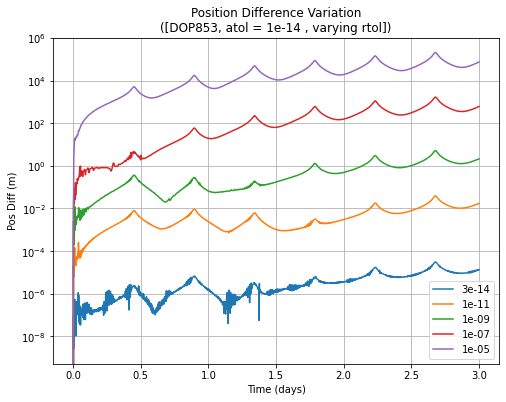

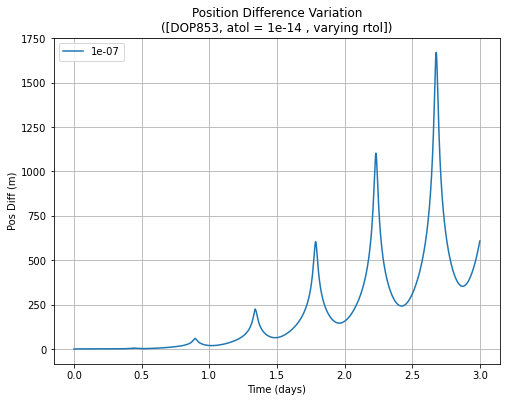

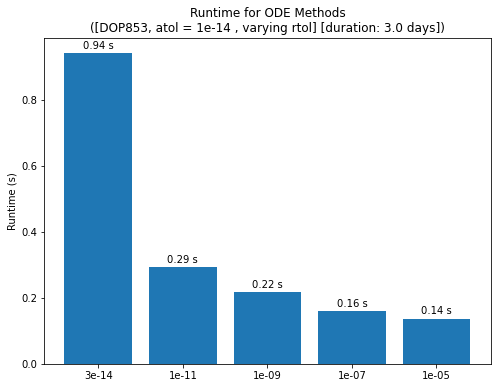

In [2]:
from satmad.propagation.tests.num_prop_analysis.num_prop_analysis_engine import plot_pos_diff, plot_runtimes

session_name = f"[DOP853, atol = {atol} , varying rtol]"

# Plot pos differences
plot_pos_diff(cases, title=session_name, logscale_plot=True)

# Plot runtime for one case to see its behaviour
plot_pos_diff({"1e-07": cases["1e-07"]}, title=f"{session_name}", logscale_plot=False)

# Plot runtimes
plot_runtimes(
    cases,
    title=f"{session_name} [duration: {duration.to_value(u.day)} days]",
    logscale_plot=False,
)


Plotting the error behaviour, the differences with respect to the near-circular LEO case become clearer. In the first
plot, the error increases with higher tolerance, but there is a periodic artifact overlaid on the overall error growth.
This is more evident in the second plot with the tolerance at a relatively high value of 1e-07, where the error
increases every periapsis and decreases towards the apoapsis. Furthermore, the overall error increases quadratically.
The first plot shows that this behaviour is seen in all cases, but the magnitude is much more limited for
lower tolerance cases.

This demonstrates that the solvers have difficulty in dealing with these highly elliptic orbits, presumably
not lowering the stepsizes quickly enough around the periapsis. That said, the overall error can still be kept low via
selecting the tolerances appropriately.

Finally, the runtimes are much shorter than the near-circular LEO case. This suggests that the average stepsizes
are significantly larger than the near-circular LEO case, thanks to the slow dynamics around apoapsis.

## Impact of Eccentricity

To see the impact of eccentricity more clearly, we go back to the definition of the orbit and generate orbits with
decreasing eccentricity, keeping all the other orbital elements constant.

In [3]:
stepsize = 120 * u.s
solver_type = ODESolverType.DOP853
rtol = 1e-11
atol = 1e-11
duration = 4.0 * u.day

line1 = "1 23840U 96020B   18198.38669861 -.00000081  00000-0  00000+0 0  9997"
line2 = "2 23840  21.5075 284.9295 6975939  94.1963 356.6140  2.24211004182606"

seed_tle = TLE.from_tle(line1, line2, name)

ecc_list = [0.001, 0.1, 0.25, 0.5, 0.7]
tle_list = []
for ecc in ecc_list:
    tle = TLE.from_tle(line1, line2, name)
    tle.eccentricity = ecc
    tle_list.append(tle)

The next step is to generate a truth trajectory for each case as well as a higher tolerance test case and compute the
difference.


In [4]:
cases = {}
type(cases)

# run all cases
for tle in tle_list:
    name = str(tle.eccentricity)

    rv_init = SGP4Propagator().propagate(tle, tle.epoch)

    # run propagation and get truth trajectory
    truth_traj = propagation_engine(
        rv_init,
        stepsize,
        ODESolverType.DOP853,
        init_time_offset,
        duration,
        rtol=3e-14,
        atol=1e-15,
    )

    analyse_pos_along_trajectory(
        truth_traj,
        cases,
        name,
        rv_init,
        stepsize,
        solver_type,
        init_time_offset,
        duration,
        rtol,
        atol,
    )

**** Case: 0.001 ****
Runtime: 0.7652 s seconds
max pos diff: 0.002384523563488526 m
**** Case: 0.1 ****
Runtime: 0.7258 s seconds
max pos diff: 0.200962078153918 m
**** Case: 0.2 ****
Runtime: 0.7956 s seconds
max pos diff: 0.6609487664461389 m
**** Case: 0.4 ****
Runtime: 0.9153 s seconds
max pos diff: 1.062991928263656 m
**** Case: 0.6 ****
Runtime: 1.0248 s seconds
max pos diff: 0.6211980306828983 m
**** Case: 0.7 ****
Runtime: 1.4040 s seconds
max pos diff: 1.59594729877289 m


This exercise shows that, for low eccentricities, the error is generally lower. However, for high eccentricities
(starting from e=0.2 case and up) the error is higher, but it seems to be not very tightly coupled to the eccentricity.
However, the amplitude of the periodic variation in error is still a function of eccentricity.


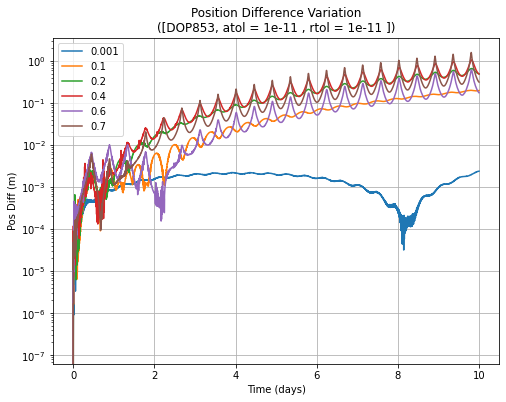

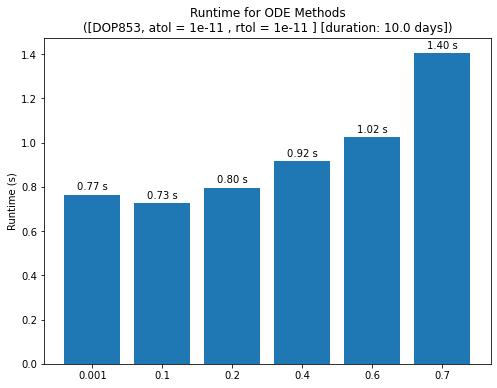

In [5]:
session_name = f"[DOP853, atol = {atol} , rtol = {rtol} ]"

# Plot pos differences
plot_pos_diff(cases, title=session_name, logscale_plot=True)

# Plot runtimes
plot_runtimes(
    cases,
    title=f"{session_name} [duration: {duration.to_value(u.day)} days]",
    logscale_plot=False,
)

The plots illustrate this behaviour better, where the e=0.001 maintains a very low error, other cases have sharply
increasing errors.

Finally, the runtimes are generally low for lower eccentricities, increasing as the eccentricity
increases. This is due to the increasingly faster dynamics around the periapsis requiring smaller timesteps.

The results are clearer for longer propagation durations, but Jupyter runtime limits may pose some limits.
The `main` for this analysis is
[here in Github](https://github.com/egemenimre/satmad/blob/master/satmad/propagation/tests/num_prop_analysis/num_prop_analysis_ecc.py)
for you to play with the results and change the analysis cases. The relationship between increasing eccentricity
and increasing runtimes are more evident in longer propagations, as well as the weak relationship of eccentricity
to propagation accuracy, thanks to the adaptive numerical integrators.
